In [2]:
## import
import lamindb as ln
import scanpy as sc

from scprint import scPrint
from scprint.dataloader import Collator, AnnDataCollator
from scdataloader.data import SimpleAnnDataset, Dataset
from scdataloader import Preprocessor
from torch.utils.data import DataLoader

from scdataloader.utils import load_genes

import numpy as np
import anndata as ad
from scipy.sparse import csr_matrix
import pandas as pd
import tqdm

from scvi.data import AnnDataManager
from scvi.data.fields import CategoricalObsField, LayerField
from scvi.dataloaders import AnnDataLoader
import scvi

from scib_metrics.benchmark import Benchmarker

from lightning.pytorch import Trainer

%load_ext autoreload
%autoreload 2

import torch
torch.set_float32_matmul_precision('medium')


💡 lamindb instance: jkobject/scprint


2024-02-08 09:19:12,463:INFO - Created a temporary directory at /tmp/tmpuksfyx4p
2024-02-08 09:19:12,468:INFO - Writing /tmp/tmpuksfyx4p/_remote_module_non_scriptable.py
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWarning: jax.core.Shape is deprecated. Use Shape = Sequence[int | Any].
  Shape = jax.core.Shape
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:54: DeprecationWarning: jax.random.KeyArray is deprecated. Use jax.Array for annotations, and jax.dtypes.issubdtype(arr.dtype, jax.dtypes.prng_key) for runtime detection of typed prng keys (i.e. keys created with jax.random.key).
For more information, see https://jax.readthedocs.io/en/latest/jep/9263-typed-keys.html
  PRNGKey = jax.random.KeyArray
2024-02-08 09:19:12,468:INFO - Writing /tmp/tmpuksfyx4p/_remote_module_non_scriptable.py
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/chex/_src/pytypes.py:53: DeprecationWar

## preparing the model

In [4]:
#model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/urxxwu28/checkpoints/epoch=0-step=20000.ckpt')
model = scPrint.load_from_checkpoint('../../data/tensorboard/scprint_test/fi77chjp/checkpoints/epoch=0-step=20000.ckpt')

In [5]:
ensembl = load_genes(['NCBITaxon:9606'])
ensembl['ensembl_gene_id'] = ensembl.index

## Loading the data

In [6]:
adata = sc.read(
    "data/pancreas_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539828",
)


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/X' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/specs/registry.py:249: OldFormatWarning: Element '/layers/counts' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=get_spec(elem))


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/tech' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/__categories/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/celltype' was written without encoding metadata.
  return func(*args, **kwargs)
/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_io/utils.py:205: OldFormatWarning: Element '/obs/size_factors' was written without encoding

In [19]:
#adata = sc.read(
#    "data/lung_atlas.h5ad",
#    backup_url="https://figshare.com/ndownloader/files/24539942",
#)

In [20]:
#adata = sc.read_h5ad('/home/ml4ig1/scprint/.lamindb/BljRloq1xjcxRNDpejzI.h5ad')

In [21]:
Preprocessor()(adata.copy())
# cannot preprocess (first of all not raw counts and also doesn't have standardized values)

ValueError: Data is not raw counts, please check layers, find raw data, or bypass with force_preprocess

In [7]:
# You need to use counts
adata.X = adata.layers['counts']
del adata.layers

In [8]:
# you need to have ensembl gene ids 
# # removing the other ones
var = adata.var.merge(ensembl.drop_duplicates('symbol').set_index('symbol', drop=False), left_index=True, right_index=True, how='inner').sort_values(by="ensembl_gene_id").set_index('ensembl_gene_id')
adata = adata[:, var['symbol']]
adata.var = var

# adding back the missing genes
unseen = set(ensembl.index) - set(adata.var.index)
# adding them to adata
emptyda = ad.AnnData(
    csr_matrix((adata.shape[0], len(unseen)), dtype=np.float32),
    var=pd.DataFrame(index=list(unseen)),
    obs=pd.DataFrame(index=adata.obs.index),
)
adata = ad.concat([adata, emptyda], axis=1, join="outer", merge="only")
# do a validation function
adata.uns["unseen_genes"] = list(unseen)
adata = adata[:, adata.var.sort_index().index]

# Add at least the organism you are working with
adata.obs['organism_ontology_term_id'] = "NCBITaxon:9606"
adata

AnnData object with n_obs × n_vars = 16382 × 70116
    obs: 'tech', 'celltype', 'size_factors', 'organism_ontology_term_id'
    var: 'symbol', 'ncbi_gene_id', 'biotype', 'description', 'synonyms', 'mt', 'ribo', 'hb', 'organism'
    uns: 'unseen_genes'

In [147]:
adataset = SimpleAnnDataset(adata, obs_to_output=['organism_ontology_term_id'])
col = Collator(organisms=["NCBITaxon:9606",], valid_genes=model.genes, how="most expr", max_len=2000,add_zero_genes = 200 )#mdataset.encoder['organism_ontology_term_id'])
dataloader = DataLoader(adataset, collate_fn=col, batch_size=32, num_workers=2, shuffle=False)

/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [ ]:
#dataloader = AnnLoader([adata], collate_fn=AnnDataCollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 0}), batch_size=32, num_workers=1)

In [ ]:
# dataloader = AnnDataLoader(adata_manager, collate_fn=SCVICollator(max_len=5000, organisms=["NCBITaxon:9606",], org_to_id={'NCBITaxon:9606': 0}), batch_size=32, num_workers=1)

In [148]:
for i in dataloader:
    print(i["x"].shape)
    break

torch.Size([32, 2200])



In [149]:
trainer = Trainer(precision=16, limit_predict_batches=10)

INFO: Using 16bit Automatic Mixed Precision (AMP)
2024-02-08 11:17:19,871:INFO - Using 16bit Automatic Mixed Precision (AMP)
2024-02-08 11:17:19,871:INFO - Using 16bit Automatic Mixed Precision (AMP)
INFO: GPU available: True (cuda), used: True
2024-02-08 11:17:19,908:INFO - GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
2024-02-08 11:17:19,911:INFO - TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
2024-02-08 11:17:19,914:INFO - IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
2024-02-08 11:17:19,917:INFO - HPU available: False, using: 0 HPUs


In [29]:
model.labels, model.pred_embedding

['cell_type_ontology_term_id',
 'disease_ontology_term_id',
 'assay_ontology_term_id',
 'self_reported_ethnicity_ontology_term_id',
 'sex_ontology_term_id',
 'organism_ontology_term_id']

In [20]:
adata.obs['tech'].value_counts()


inDrop3       3605
smartseq2     2394
celseq2       2285
inDrop1       1937
inDrop2       1724
smarter       1492
inDrop4       1303
celseq        1004
fluidigmc1     638
Name: tech, dtype: int64

In [21]:
adata.obs.celltype.value_counts()

alpha                 5493
beta                  4169
ductal                2142
acinar                1669
delta                 1055
gamma                  699
activated_stellate     464
endothelial            313
quiescent_stellate     193
macrophage              79
mast                    42
epsilon                 32
schwann                 25
t_cell                   7
Name: celltype, dtype: int64

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2024-02-08 11:17:27,359:INFO - LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/ml4ig1/miniconda3/envs/scprint/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 320 × 128
    obs: 'pred_cell_type_ontology_term_id', 'pred_disease_ontology_term_id', 'pred_assay_ontology_term_id', 'pred_self_reported_ethnicity_ontology_term_id', 'pred_sex_ontology_term_id', 'pred_organism_ontology_term_id', 'leiden'
    uns: 'neighbors', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    obsp: 'distances', 'connectivities'
couldn't log to tensorboard
couldn't log to wandb


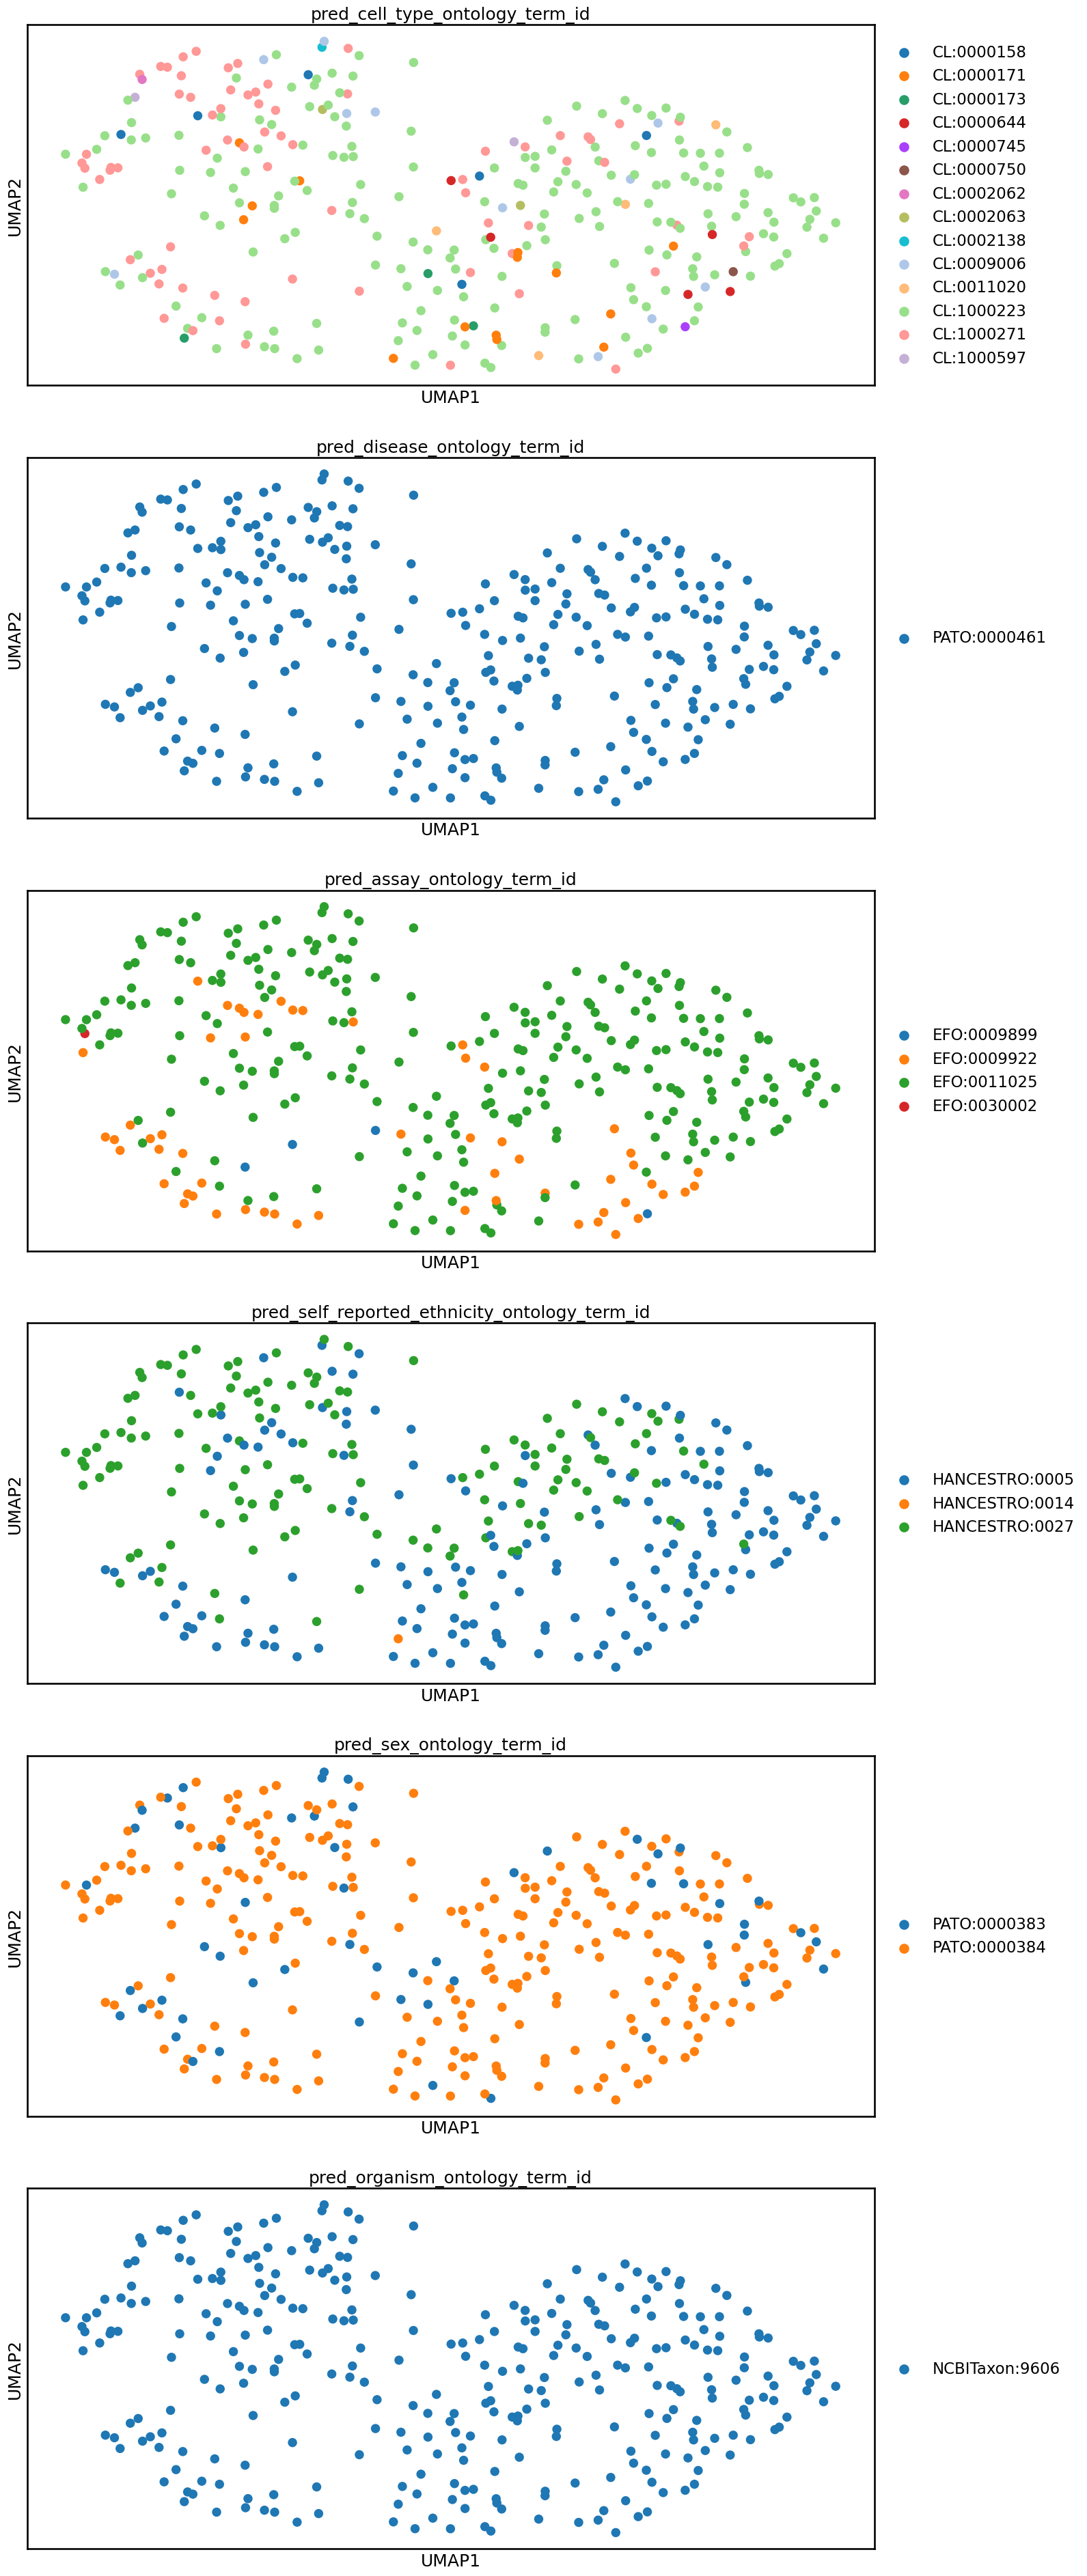

In [150]:
predictions = trainer.predict(model, dataloader)

In [157]:
expr = np.array(model.expr_pred[0])

In [158]:
expr[np.random.binomial(1, p=np.array(torch.nn.functional.sigmoid(model.expr_pred[2].to(torch.float32)))).astype(bool)] = 0

In [159]:
expr[expr<=0.5] = 0
expr[(expr<=1) & (expr>0.5)] = 1

In [142]:
model.embs.shape

torch.Size([320, 128])

In [155]:
adata.obs.iloc[:320]

,tech,celltype,size_factors,organism_ontology_term_id
D101_5,celseq,gamma,0.028492,NCBITaxon:9606
D101_43,celseq,gamma,0.079348,NCBITaxon:9606
D101_93,celseq,gamma,0.037932,NCBITaxon:9606
D102_4,celseq,gamma,0.047685,NCBITaxon:9606
D172444_23,celseq,gamma,0.038683,NCBITaxon:9606
...,...,...,...,...
HP1525301T2D_B5,smartseq2,gamma,0.978228,NCBITaxon:9606
HP1525301T2D_E3,smartseq2,gamma,1.448675,NCBITaxon:9606
HP1525301T2D_G23,smartseq2,gamma,1.559879,NCBITaxon:9606
HP1525301T2D_J18,smartseq2,gamma,0.760788,NCBITaxon:9606


In [153]:
pred_adata.obs

,pred_cell_type_ontology_term_id,pred_disease_ontology_term_id,pred_assay_ontology_term_id,pred_self_reported_ethnicity_ontology_term_id,pred_sex_ontology_term_id,pred_organism_ontology_term_id,leiden
0,CL:1000271,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000383,NCBITaxon:9606,4
1,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
2,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
3,CL:1000223,PATO:0000461,EFO:0009922,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,4
4,CL:1000223,PATO:0000461,EFO:0011025,HANCESTRO:0027,PATO:0000383,NCBITaxon:9606,5
...,...,...,...,...,...,...,...
315,CL:0009006,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,2
316,CL:0000750,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,0
317,CL:0000644,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,2
318,CL:0009006,PATO:0000461,EFO:0011025,HANCESTRO:0005,PATO:0000384,NCBITaxon:9606,0


In [151]:
pred_adata = sc.read_h5ad(
    model.logger.save_dir
    + "/step_"
    + str(model.global_step)
    + "_umap_"
    + ".h5ad"
)

In [ ]:
colname = ["pred_" + i for i in self.labels]
obs = np.array(self.pred.to(device="cpu", dtype=torch.int32))
obs = np.array(
    [
        [self.label_decoders[self.labels[i]][n] for n in name]
        for i, name in enumerate(obs.T)
    ]
).T

In [143]:
model.pred.shape

torch.Size([320, 6])

In [ ]:
AnnData(X=expr.astype(int), obs=obs, var=adata.var)

In [97]:
expr[:32].astype(int).mean()

10.69109375

In [106]:
i["x"].mean()

tensor(4.4559)

In [107]:
expr[:32].mean(), expr[:32].max(), (expr[:32]==0).sum()

(11.129551, 2882.04)

In [161]:
expr[:32].mean(), expr[:32].max(), (expr[:32]==0).sum()

(6.1299295, 2174.4126, 2944)

In [162]:
i['x'].mean(), i['x'].max(), (i['x']==0).sum()

(tensor(4.4607), tensor(1597.0111), tensor(6153))

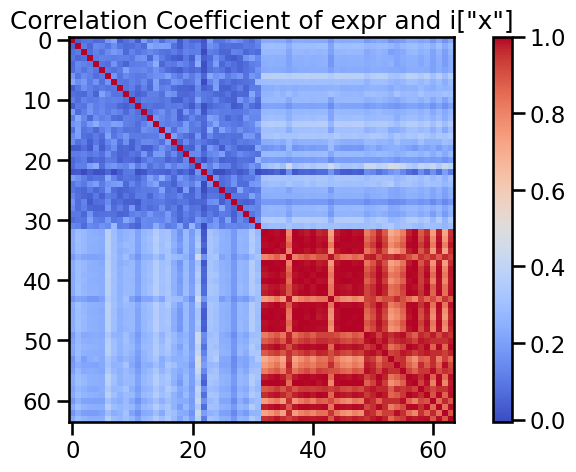

In [160]:
import matplotlib.pyplot as plt
import numpy as np

# Compute correlation coefficient
corr_coef = np.corrcoef(expr[:32].astype(int), i['x'])

# Plot correlation coefficient
plt.figure(figsize=(10, 5))
plt.imshow(corr_coef, cmap='coolwarm', interpolation='none')
plt.colorbar()
plt.title('Correlation Coefficient of expr and i["x"]')
plt.show()


In [ ]:
adata.X.iloc[0].to_array()

In [ ]:
model

## results from running it on most famous methods

![](https://scib-metrics.readthedocs.io/en/stable/_images/72bdb33d77de77ce505e24fef1d700c2b91985b1d3fcce1c2b1dd7a35c8a647f.png)

In [ ]:
## load a random dataset

In [ ]:
## do scGPT finetuning task (reusing the helper functions I have) and the notebook that they provide

In [ ]:
## create a task/function for scPrint

In [ ]:
## try to do an embedding from the regulon / single cell type matrix outputted by scenic

In [ ]:
## push it to a function on BenGRN